<a href="https://colab.research.google.com/github/GuilhermeLopesBertacini/Keras-Workshop/blob/main/Keras_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# Divisão do dataset
Vamos dividir o dataset em três porções para o treinamento:

 **Treinamento**: 70% dos dados;

 **Validação**: 20% dos dados;

 **Teste**: 10% dos dados

In [ ]:
# Adicionando imports para carregar datasets
import tensorflow_datasets as tfds

( ds_train, ds_valid, ds_test ), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:35%]', 'train[35%:45%]', 'train[45%:50%]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
    )

print( "Tamanho do dataset de treinamento: %i" % len( ds_train ) )
print( "Tamanho do dataset de validação: %i" % len( ds_valid ) )
print( "Tamanho do dataset de testes: %i " % len( ds_test ) )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incomplete9IML29/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.
Tamanho do dataset de treinamento: 8142
Tamanho do dataset de validação: 2326
Tamanho do dataset de testes: 1163 


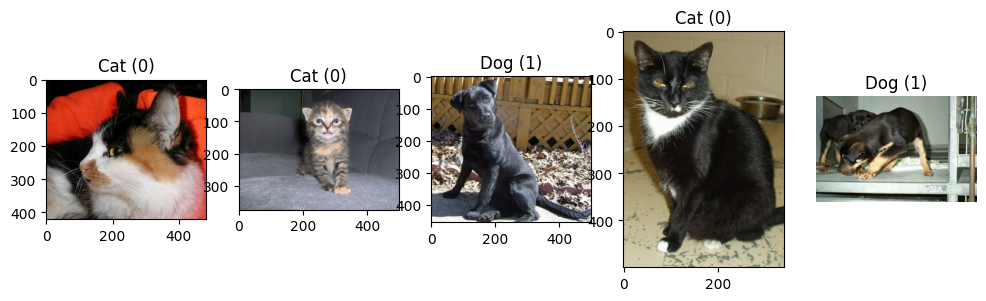

In [ ]:
import matplotlib.pyplot as plt

images_to_show = 5

# Criando um subplot com 5 figuras
_, axes = plt.subplots(1, images_to_show, figsize=(12, 6))  # Adjust rows, cols, and figsize as needed

# Pegando alguns exemplos do dataset
train_examples = ds_train.take(images_to_show)

# Observando a documentação do dataset (https://www.tensorflow.org/datasets/catalog/cats_vs_dogs)
# sabemos que:

labels_dict = {
    0: "Cat (0)",
    1: "Dog (1)"
}

plt.axis('off')

for idx, data in enumerate(train_examples):

    image = data[0]
    label = data[1]

    axes[idx].title.set_text( labels_dict[label.numpy()] )
    axes[idx].imshow( image )

Hiperparâmetros e outras configurações para salvar o modelo

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
MODEL_WEIGHTS_PATH = '/content/drive/MyDrive/Colab Notebooks/keras_feature_map_workshop/weights/'


# Definindo hyperparâmetros da rede para treinamento
BATCH_SIZE = 64
IMAGE_SIZE = (224,224)
EPOCHS = 3
LR = 1e-3   # Learning rate

Mounted at /content/drive


Pré processando os dados de treinamento


In [ ]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""

  return tf.cast(tf.image.resize(image, size=IMAGE_SIZE ), tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


ds_valid = ds_train.cache()
ds_valid = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_valid = ds_train.batch(BATCH_SIZE)
ds_valid = ds_train.prefetch(tf.data.AUTOTUNE)


ds_test = ds_train.cache()
ds_test = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_test = ds_train.batch(BATCH_SIZE)
ds_test = ds_train.prefetch(tf.data.AUTOTUNE)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Resizing, MaxPool2D
from keras.applications import MobileNetV3Small
from keras.models import load_model

model = None

model = Sequential(
    [
        Conv2D(32, kernel_size=3, activation='relu', input_shape=( IMAGE_SIZE[0], IMAGE_SIZE[1], 3) ),
        Conv2D(64, kernel_size=3, strides=(3,3), activation='relu'),
        MaxPool2D(pool_size=(2,2)),

        Conv2D(64, kernel_size=3, strides=(3,3), activation='relu'),
        MaxPool2D(pool_size=(2,2)),

        Conv2D(128, kernel_size=3, strides=(3,3), activation='relu'),
        MaxPool2D(pool_size=(2,2)),

        Flatten(),
        Dense(64, activation='relu'),


        Dense(1, activation='sigmoid')
    ]
)

# model.build(input_shape=(None, 224, 224, 3))
# model.summary()

model.compile(
    optimizer = keras.optimizers.Adam( LR ),
    loss = keras.losses.BinaryCrossentropy(from_logits=False),
    metrics = [keras.metrics.BinaryAccuracy()],
)

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print('Esse colab tem uma GPU, treinando e salvando')

    model.fit(
        ds_train,
        epochs=EPOCHS,
        validation_data=ds_valid,
    )

    model.save( MODEL_WEIGHTS_PATH + 'model_3.keras')

else:


    print('Esse colab não está com GPU ligada, vamos só carregar')
    model = load_model( MODEL_WEIGHTS_PATH+'model_3.keras' )


Esse colab tem uma GPU, treinando e salvando
Epoch 1/3
128/128 [==============================] - 18s 72ms/step - loss: 0.6845 - binary_accuracy: 0.5361 - val_loss: 0.6786 - val_binary_accuracy: 0.5743
Epoch 2/3
128/128 [==============================] - 8s 65ms/step - loss: 0.6698 - binary_accuracy: 0.5882 - val_loss: 0.6937 - val_binary_accuracy: 0.5247
Epoch 3/3
128/128 [==============================] - 8s 65ms/step - loss: 0.6391 - binary_accuracy: 0.6250 - val_loss: 0.6091 - val_binary_accuracy: 0.6672


Testando o modelo (Treinado ou Carregado...)

In [ ]:
loss, acc = model.evaluate( ds_test );

128/128 [==============================] - 3s 24ms/step - loss: 0.6091 - binary_accuracy: 0.6672


1/1 [==============================] - 0s 20ms/step


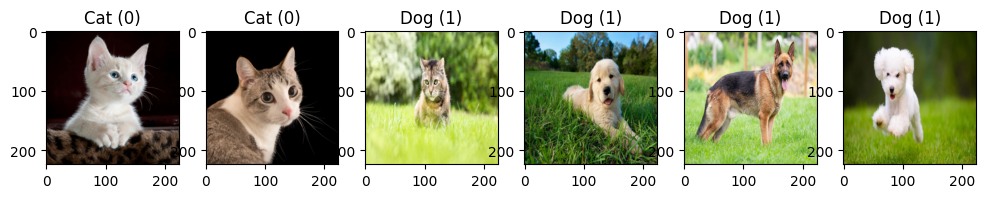

In [ ]:
import requests
from PIL import Image
import io
import numpy as np


def download_img( url ):
    response = requests.get(url)
    image_data = response.content

    raw_image = Image.open( io.BytesIO( image_data ) )

    raw_image = raw_image.resize((224, 224))
    image = np.array( raw_image )/255.0
    image = np.expand_dims(image,axis=0)

    return image


def predict_web_img( url ):

    image = download_img( url )

    predictions = model.predict(image)

    output_class = 0 # cat

    if( predictions[0] > 0.5):
        output_class = 1 # dog

    return (image, output_class)


cat_url_1 = "https://images.pexels.com/photos/45201/kitty-cat-kitten-pet-45201.jpeg"
cat_url_2 = "https://i.natgeofe.com/n/548467d8-c5f1-4551-9f58-6817a8d2c45e/NationalGeographic_2572187_square.jpg"
cat_url_3 = "https://www.purina.co.nz/sites/default/files/styles/ttt_image_510/public/2020-12/Why%20Do%20Cats%20Eat%20Grass2.jpg"
dog_url_1 = "https://www.southernliving.com/thmb/a4b73J7C4S4wgSmymmEgXRCmACA=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/GettyImages-185743593-2000-507c6c8883a44851885ea4fbc10a2c9e.jpg"
dog_url_2 = "https://cdn.britannica.com/79/232779-050-6B0411D7/German-Shepherd-dog-Alsatian.jpg"
dog_url_3 = "https://thumbor.forbes.com/thumbor/fit-in/900x510/https://www.forbes.com/advisor/wp-content/uploads/2023/07/top-20-small-dog-breeds.jpeg.jpg"


images = [
    (cat_url_1, 0),
    (cat_url_2, 0),
    (cat_url_3, 0),
    (dog_url_1, 1),
    (dog_url_2, 1),
    (dog_url_3, 1),
]


# Criando um subplot com 5 figuras
_, axes = plt.subplots(1, len(images), figsize=(12, 6))  # Adjust rows, cols, and figsize as needed

for i in range( len(images) ):
    image, pred_class = predict_web_img( images[i][0] )
    axes[i].title.set_text( labels_dict[pred_class] )
    axes[i].imshow( image[0] )


Nome do layer: conv2d, dimensões de saída: (None, 222, 222, 32)

Nome do layer: conv2d_1, dimensões de saída: (None, 74, 74, 64)

Nome do layer: max_pooling2d, dimensões de saída: (None, 37, 37, 64)

Nome do layer: conv2d_2, dimensões de saída: (None, 12, 12, 64)

Nome do layer: max_pooling2d_1, dimensões de saída: (None, 6, 6, 64)

Nome do layer: conv2d_3, dimensões de saída: (None, 2, 2, 128)

Nome do layer: max_pooling2d_2, dimensões de saída: (None, 1, 1, 128)

Nome do layer: flatten, dimensões de saída: (None, 128)

Nome do layer: dense, dimensões de saída: (None, 64)

Nome do layer: dense_1, dimensões de saída: (None, 1)

1/1 [==============================] - 0s 206ms/step
(1, 222, 222, 32)


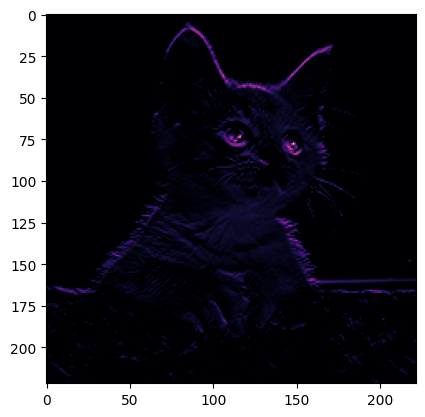

In [ ]:
for layer in model.layers:
    print( f'Nome do layer: {layer.name}, dimensões de saída: {layer.output_shape}\n' )

visualization_model = tf.keras.models.Model(
    inputs=model.input,
    outputs=model.layers[0].output )

layer_output = visualization_model.predict( download_img(cat_url_1) )

print( layer_output.shape )

# Exibindo um filtro específico da rede
plt.imshow( layer_output[0,:,:,0], cmap='magma' )

1/1 [==============================] - 0s 39ms/step
layer_name: conv2d
feature_map_shape: (222, 222, 32)


<Figure size 640x480 with 0 Axes>

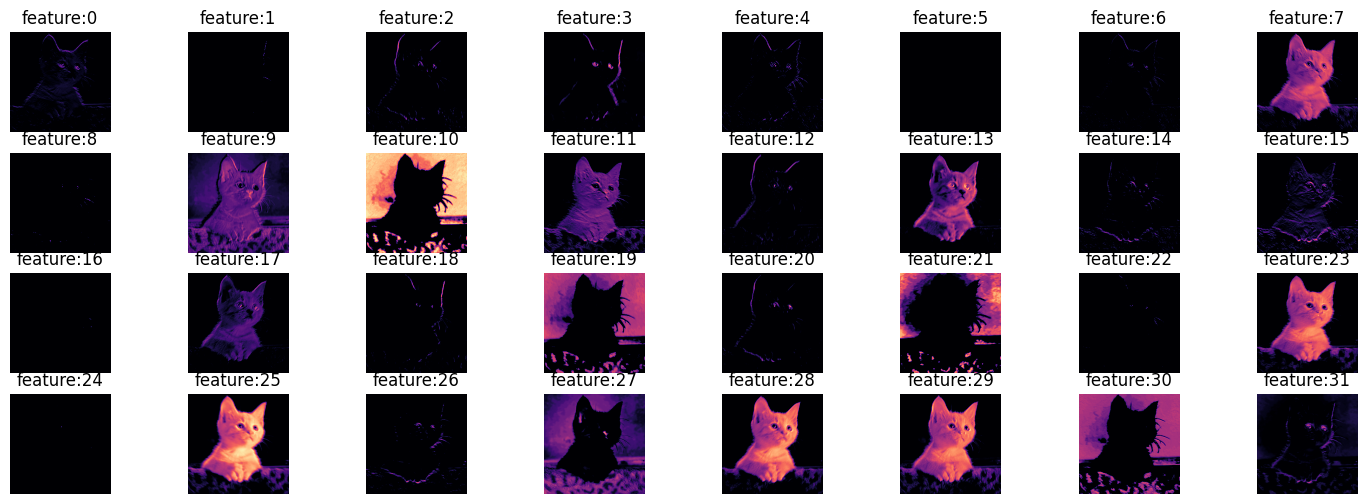

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_maps( input_image, model, layer_idx ):

    layer_names = [layer.name for layer in model.layers]

    # Cria um novo modelo derivado do modelo original.
    # Como entrada, teremos a entrada do modelo original e, como saída, o output
    # de uma camada específica do modelo original
    visualization_model = tf.keras.models.Model( inputs=model.input, outputs=model.layers[layer_idx].output )

    nmbr_channels = model.layers[layer_idx].output_shape[-1]

    # Retornando os feature maps do modelo
    successive_feature_maps = visualization_model.predict( input_image )

    # Criando um subplot com 4 figuras
    plt.figure()
    _, axes = plt.subplots(int(nmbr_channels/8), 8, figsize=(18, 6))  # Adjust rows, cols, and figsize as needed

    for layer_name, feature_map in zip(layer_names[layer_idx:], successive_feature_maps[0:]):
        print( f"layer_name: {layer_name}" )
        print( f"feature_map_shape: {feature_map.shape}" )

        # Process feature map for visualization
        n_features = feature_map.shape[-1]
        size = feature_map.shape[1]
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):

            x = feature_map[ :, :, i]

            row_idx = int(i/8)
            column_idx = int(i%8)

            axes[row_idx][column_idx].set_title(f'feature:{i}')
            axes[row_idx][column_idx].axis(False)
            axes[row_idx][column_idx].grid(False)
            axes[row_idx][column_idx].imshow( x, cmap='magma' )


# passaro = download_img( 'https://img.freepik.com/fotos-gratis/foto-vertical-de-uma-adoravel-periquita_181624-42514.jpg')
# predictions = model.predict(passaro)
# print( predictions )

plot_feature_maps( download_img(cat_url_1), model, 0)

1/1 [==============================] - 0s 39ms/step
layer_name: conv2d
feature_map_shape: (222, 222, 32)


<Figure size 640x480 with 0 Axes>

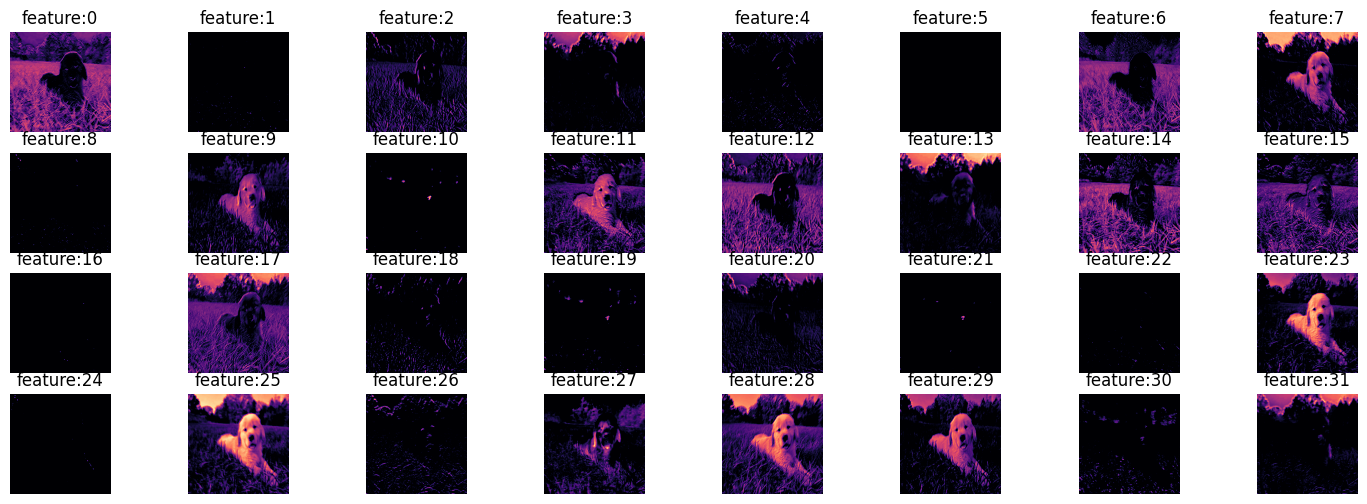

In [ ]:
plot_feature_maps( download_img(dog_url_1), model, 0)

1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step


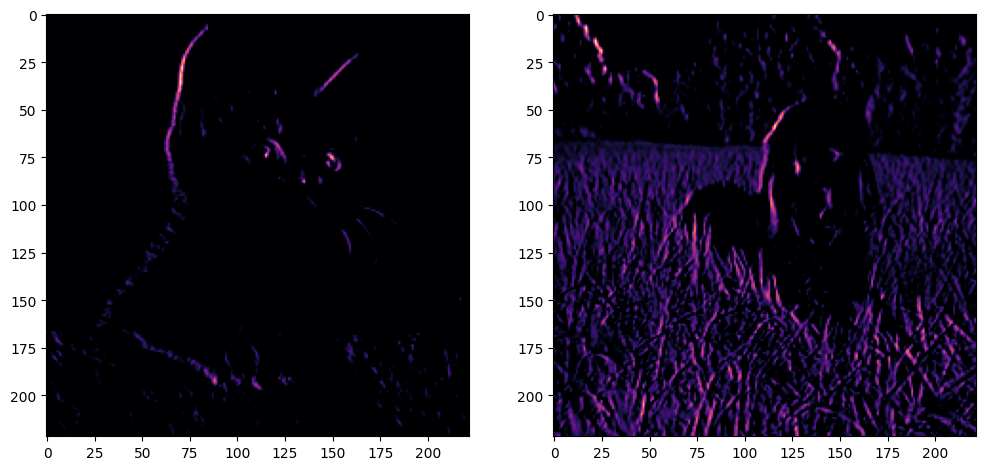

In [ ]:
def get_layer_feature_img( input_model, layer_idx, feature_idx, input_image):

    visualization_model = tf.keras.models.Model( inputs=input_model.input, outputs=input_model.layers[layer_idx].output )

    output = visualization_model.predict( input_image )

    return output[0,:,:,feature_idx ]

_, axes = plt.subplots(1, 2, figsize=(12,12) )
axes[0].imshow( get_layer_feature_img( model, 0, 2, download_img( cat_url_1 ) ), cmap='magma')
axes[1].imshow( get_layer_feature_img( model, 0, 2, download_img( dog_url_1 ) ), cmap='magma')

Treinando mais um pouco

In [ ]:
EPOCHS=15

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print('Esse colab tem uma GPU, treinando e salvando')

    model_15 = tf.keras.models.clone_model(model)

    model_15.compile(
        optimizer = keras.optimizers.Adam( LR ),
        loss = keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [keras.metrics.BinaryAccuracy()],
    )

    model_15.fit(
        ds_train,
        epochs=EPOCHS,
        validation_data=ds_valid,
    )

    model_15.save( MODEL_WEIGHTS_PATH + 'model_15.keras')

else:
    print('Esse colab não está com GPU ligada, vamos só carregar')
    model_15 = load_model( MODEL_WEIGHTS_PATH+'model_15.keras' )

Esse colab tem uma GPU, treinando e salvando
Epoch 1/15
128/128 [==============================] - 10s 67ms/step - loss: 0.6865 - binary_accuracy: 0.5377 - val_loss: 0.6640 - val_binary_accuracy: 0.5927
Epoch 2/15
128/128 [==============================] - 8s 65ms/step - loss: 0.6602 - binary_accuracy: 0.5967 - val_loss: 0.6362 - val_binary_accuracy: 0.6277
Epoch 3/15
128/128 [==============================] - 8s 65ms/step - loss: 0.6285 - binary_accuracy: 0.6420 - val_loss: 0.5992 - val_binary_accuracy: 0.6669
Epoch 4/15
128/128 [==============================] - 8s 65ms/step - loss: 0.6115 - binary_accuracy: 0.6594 - val_loss: 0.5647 - val_binary_accuracy: 0.7081
Epoch 5/15
128/128 [==============================] - 8s 66ms/step - loss: 0.5770 - binary_accuracy: 0.6944 - val_loss: 0.5498 - val_binary_accuracy: 0.7093
Epoch 6/15
128/128 [==============================] - 8s 65ms/step - loss: 0.5432 - binary_accuracy: 0.7264 - val_loss: 0.5139 - val_binary_accuracy: 0.7405
Epoch 7/15
1

Visualizando feature maps depois de treinar


1/1 [==============================] - 0s 39ms/step


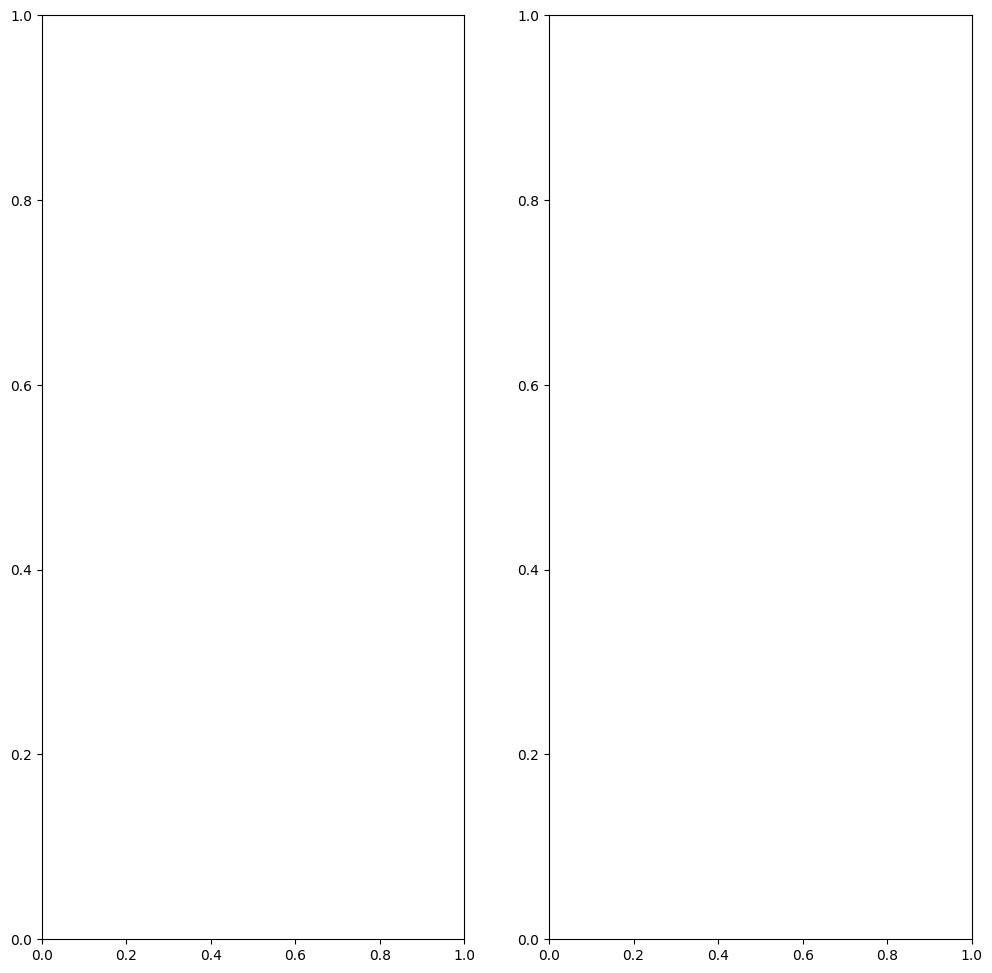

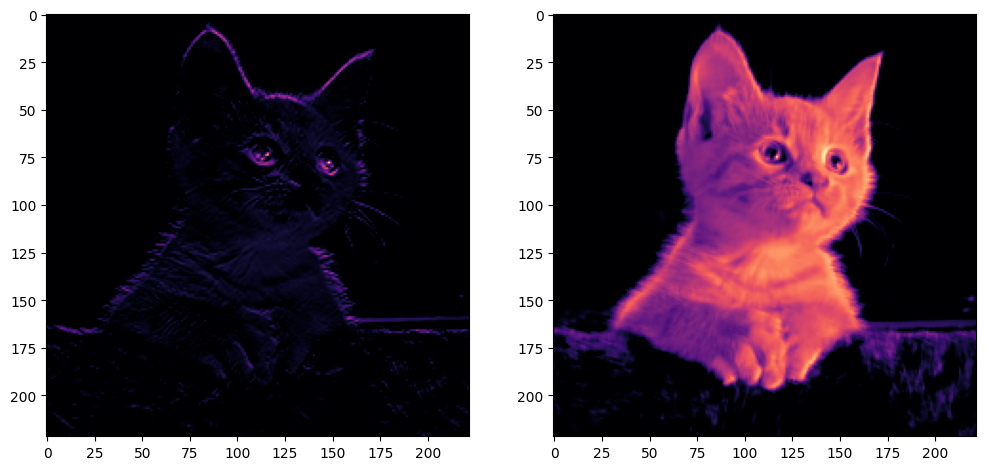

<Figure size 640x480 with 0 Axes>

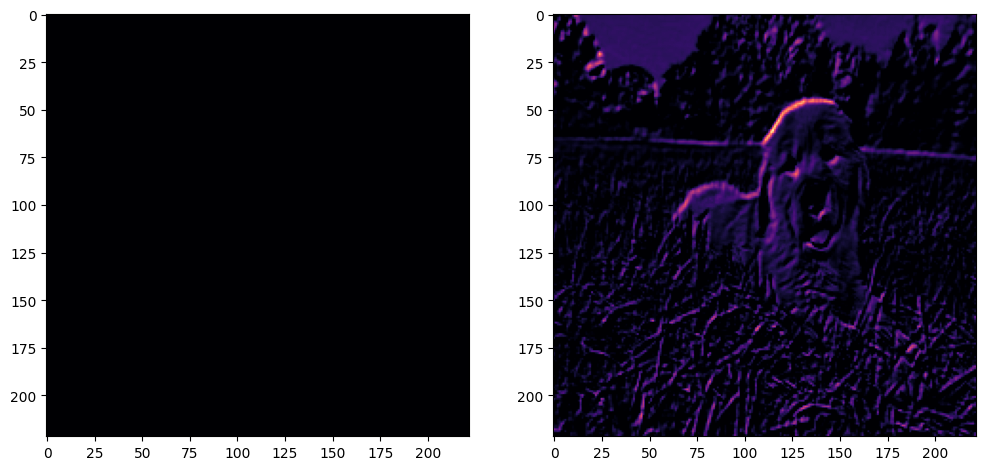

In [ ]:
_, axes = plt.subplots(1, 2, figsize=(12,12) )

# model, foi treinado em 5 épocas
# model_15, foi treinado em 15 épocas

# Abaixo, conseguimos observar quais são as alterações do modelo quando o treinamento avança.
_, axes = plt.subplots(1, 2, figsize=(12,12) )
axes[0].imshow( get_layer_feature_img( model,    0, 0, download_img( cat_url_1 ) ), cmap='magma' )
axes[1].imshow( get_layer_feature_img( model_15, 0, 0, download_img( cat_url_1 ) ), cmap='magma' )

plt.figure()
_, axes = plt.subplots(1, 2, figsize=(12,12) )
axes[0].imshow( get_layer_feature_img( model,    0, 5, download_img( dog_url_1 ) ), cmap='magma' )
axes[1].imshow( get_layer_feature_img( model_15, 0, 5, download_img( dog_url_1 ) ), cmap='magma' )

In [ ]:
EPOCHS=50

# Check if a GPU is available
if tf.config.list_physical_devices('GPU'):
    print('Esse colab tem uma GPU, treinando e salvando')

    model_50 = tf.keras.models.clone_model(model)

    model_50.compile(
        optimizer = keras.optimizers.Adam( LR ),
        loss = keras.losses.BinaryCrossentropy(from_logits=False),
        metrics = [keras.metrics.BinaryAccuracy()],
    )

    model_50.fit(
        ds_train,
        epochs=EPOCHS,
        validation_data=ds_valid,
    )

    model_50.save( MODEL_WEIGHTS_PATH + 'model_50.keras')

else:
    print('Esse colab não está com GPU ligada, vamos só carregar')
    model_50 = load_model( MODEL_WEIGHTS_PATH+'model_50.keras' )

Esse colab tem uma GPU, treinando e salvando
Epoch 1/50
128/128 [==============================] - 10s 66ms/step - loss: 0.6867 - binary_accuracy: 0.5496 - val_loss: 0.6643 - val_binary_accuracy: 0.6145
Epoch 2/50
128/128 [==============================] - 8s 66ms/step - loss: 0.6513 - binary_accuracy: 0.6110 - val_loss: 0.6313 - val_binary_accuracy: 0.6479
Epoch 3/50
128/128 [==============================] - 8s 65ms/step - loss: 0.6235 - binary_accuracy: 0.6495 - val_loss: 0.6257 - val_binary_accuracy: 0.6342
Epoch 4/50
128/128 [==============================] - 8s 65ms/step - loss: 0.5981 - binary_accuracy: 0.6807 - val_loss: 0.5794 - val_binary_accuracy: 0.6957
Epoch 5/50
128/128 [==============================] - 8s 65ms/step - loss: 0.5517 - binary_accuracy: 0.7163 - val_loss: 0.5181 - val_binary_accuracy: 0.7448
Epoch 6/50
128/128 [==============================] - 8s 65ms/step - loss: 0.5208 - binary_accuracy: 0.7359 - val_loss: 0.4932 - val_binary_accuracy: 0.7580
Epoch 7/50
1

1/1 [==============================] - 0s 39ms/step


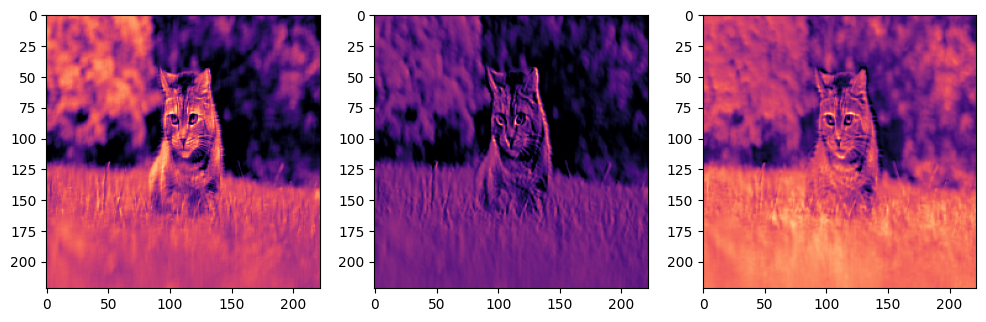

<Figure size 640x480 with 0 Axes>

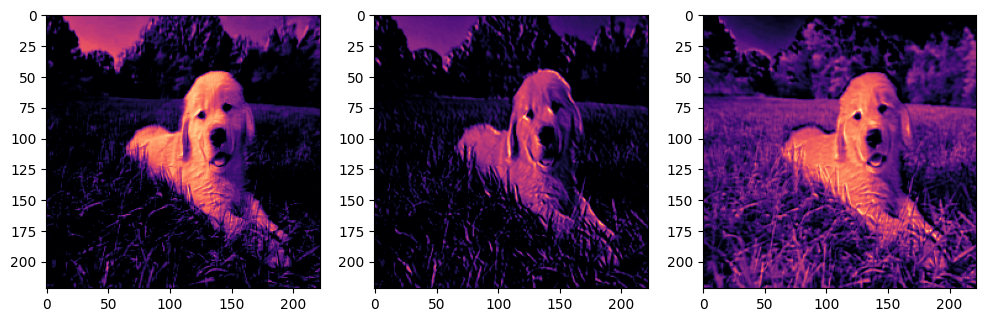

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(12,12) )

layer_nmbr = 0
feature_nmbr = 23

axes[0].imshow( get_layer_feature_img( model,    layer_nmbr, feature_nmbr, download_img( cat_url_3 ) ), cmap='magma' )
axes[1].imshow( get_layer_feature_img( model_15, layer_nmbr, feature_nmbr, download_img( cat_url_3 ) ), cmap='magma' )
axes[2].imshow( get_layer_feature_img( model_50, layer_nmbr, feature_nmbr, download_img( cat_url_3 ) ), cmap='magma' )

plt.figure()
_, axes = plt.subplots(1, 3, figsize=(12,12) )
axes[0].imshow( get_layer_feature_img( model,    layer_nmbr, feature_nmbr, download_img( dog_url_1 ) ), cmap='magma' )
axes[1].imshow( get_layer_feature_img( model_15, layer_nmbr, feature_nmbr, download_img( dog_url_1 ) ), cmap='magma' )
axes[2].imshow( get_layer_feature_img( model_50, layer_nmbr, feature_nmbr, download_img( dog_url_1 ) ), cmap='magma' )